In [29]:
import pandas as pd
import folium
import json
import math

import pandas as pd
import numpy as np

import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson

import copy

geo_counties_json = os.path.join('data','gz_2010_us_050_00_20m.json')
geo_states_json = os.path.join('data','gz_2010_us_040_00_20m.json')

# Gather Data from Separate Repo
Refresh data from source repo <br>
`git fetch --all`<br>
`git reset --hard origin/master`

## Import data into dataframes

In [30]:
try:
    counties_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
    states_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
    county_data = pd.read_csv(data_path+'us-counties.csv')
    state_data = pd.read_csv(data_path+'us-states.csv')
    print("Received latest NYT Data")
except:
    county_data = pd.read_csv('data/us-counties.csv')
    state_data = pd.read_csv('data/us-states.csv')
    print("Could not get latest NYT Data, falling back to local 4-3-20 data")
county_data = county_data.dropna()
state_data = state_data.dropna()

Received latest NYT Data


In [31]:
# Clean up State Data for ones that don't have Geo Data
remove = ["District of Columbia","Puerto Rico","Virgin Islands","Northern Mariana Islands","Guam"]
state_data = state_data[-state_data.state.isin(remove)]

## Import US Geography JSON Files

In [32]:
with open(geo_counties_json,encoding = "ISO-8859-1") as file:
    county_geo = json.load(file)
with open(geo_states_json) as file:
    state_geo = json.load(file)

In [33]:
# Sample County Geometry
# Use FIPS code as last 5 digits of GEO_ID
county_geo['features'][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]}}

In [34]:
# Sample State Geometry
state_geo['features'][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0400000US04',
  'STATE': '04',
  'NAME': 'Arizona',
  'LSAD': '',
  'CENSUSAREA': 113594.084},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-112.538593, 37.000674],
    [-112.534545, 37.000684],
    [-112.368946, 37.001125],
    [-112.35769, 37.001025],
    [-111.412784, 37.001478],
    [-111.405869, 37.001481],
    [-111.405517, 37.001497],
    [-111.189888, 37.000959],
    [-110.75069, 37.003197],
    [-110.495259, 37.003875],
    [-110.33105, 36.998216],
    [-110.000677, 36.997968],
    [-109.381226, 36.999148],
    [-109.378039, 36.999135],
    [-109.270097, 36.999266],
    [-109.268213, 36.999242],
    [-109.26339, 36.999263],
    [-109.246917, 36.999346],
    [-109.233848, 36.999266],
    [-109.181196, 36.999271],
    [-109.045223, 36.999084],
    [-109.045244, 36.969489],
    [-109.045272, 36.968871],
    [-109.045407, 36.874998],
    [-109.045433, 36.874589],
    [-109.045973, 36.002338],
    [-109.046011, 35.925896],
    

## Define Bin Sizes

In [35]:
# Equally spaced bins based on number of cases
bin_edges_states = np.linspace(0,state_data.cases.max(),50)
bin_edges_counties = np.linspace(0,county_data.cases.max(),50)

# Could do it on logarithmic scale or other method to increase / decrease "severity coloring"
# Potentially in line with county population density or based on rate of increase of cases / deaths
# Death rate based on age of population + density

## Define Color Scale
Used this tool: <br>
https://gka.github.io/palettes/#/0|s|94003a|ffffe0,ff005e,93003a|1|1

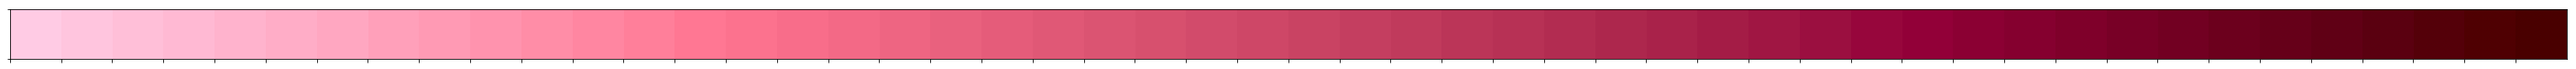

In [36]:
fifty_color_red = ['#490000', '#4f0002', '#540009', '#5a0010', '#600015', '#660019', '#6c001d', '#720022', '#780026', '#7f002a', '#85002f', '#8b0033', '#920038', '#97063c', '#9b0f40', '#a01643', '#a41c46', '#a9224a', '#ad274d', '#b22c51', '#b73155', '#bb3558', '#c03a5c', '#c43e60', '#c94363', '#ce4767', '#d24b6b', '#d7506e', '#db5472', '#e05876', '#e55c7a', '#e9617e', '#ee6582', '#f36986', '#f86d8a', '#fc728e', '#ff7793', '#ff7f9a', '#ff86a1', '#ff8da7', '#ff93ae', '#ff9ab4', '#ffa0ba', '#ffa7c1', '#ffadc7', '#ffb3cd', '#ffb9d3', '#ffbfd8', '#ffc5de', '#ffcbe4']
fifty_color_red.reverse()
color_scale = np.array(fifty_color_red)
sns.palplot(sns.color_palette(color_scale))

In [37]:
def color_coding(value, bin_edges):  
    # Returns color based on where value lies in the provided bin
    idx = np.digitize(value, bin_edges, right=True)
    return color_scale[idx]


## Generate Color based on row value

In [38]:
state_data['color'] = state_data['cases'].apply(lambda x: color_coding(x,bin_edges_states))
county_data['color'] = county_data['cases'].apply(lambda x: color_coding(x,bin_edges_counties))

## Adjust fips from float to int and fix leading zero issue

In [55]:
county_data.fips = county_data.fips.apply(lambda x: '0'+ str(int(x)) if len(str(x)) < 5 else str(int(x)))
state_data.fips = state_data.fips.apply(lambda x: '0' + str(int(x)) if len(str(x)) < 2 else str(int(x)))

In [56]:
state_data.fips

0       53
1       53
2       53
3       17
4       53
5       06
6       17
7       53
8       04
9       06
10      17
11      53
12      04
13      06
14      17
15      53
16      04
17      06
18      17
19      53
20      04
21      06
22      17
23      53
24      04
25      06
26      17
27      53
28      04
29      06
        ..
1741    25
1742    26
1743    27
1744    28
1745    29
1746    30
1747    31
1748    32
1749    33
1750    34
1751    35
1752    36
1753    37
1754    38
1756    39
1757    40
1758    41
1759    42
1761    44
1762    45
1763    46
1764    47
1765    48
1766    49
1767    50
1769    51
1770    53
1771    54
1772    55
1773    56
Name: fips, Length: 1676, dtype: object

## Make GeoJSON Lookup Dict

Potentially a index by method versus making a new cache, but this will suffice for now

In [57]:
# COUNTY
counties = county_geo['features']
counties_geo_dict = {}
for each in counties:
    counties_geo_dict[each['properties']['GEO_ID'][-5:]] = each
    
# STATE
state = state_geo['features']
states_geo_dict = {}
for each in state:
    states_geo_dict[each['properties']['STATE']] = each
    

In [58]:
# States Feature List Generation
def create_geojson_features_modded(df,geo_dict):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {}
        feature = geo_dict[row.fips]
        feature['properties']['time'] = row.date
        feature['properties']['cases'] = row.cases
        feature['properties']['style'] = {'fillColor':row['color'],'fillOpacity': 0.75,'weight':0.5}
        test = copy.deepcopy(feature)
        features.append(test)
    print("COMPLETED")
    return features

In [59]:
states_feature = create_geojson_features_modded(state_data,states_geo_dict)

> Creating GeoJSON features...
COMPLETED


In [60]:
counties_feature = create_geojson_features_modded(county_data,counties_geo_dict)

> Creating GeoJSON features...
COMPLETED


In [61]:
def make_map(features):
    print('> Making map...')
    start=[48, -102]
    USA_map = folium.Map(location=start, control_scale=True, zoom_start=5)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1D'
        , duration='P1D'
        , add_last_point=False
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM-DD'
        , time_slider_drag_update=True
    ).add_to(USA_map)
    print('> Done.')
    return USA_map


In [62]:
counties_map = make_map(counties_feature)

> Making map...
> Done.


In [63]:
counties_map.save('COVID_COUNTIES_USA.html')

In [64]:
state_map = make_map(states_feature)

> Making map...
> Done.


In [65]:
state_map.save('COVID_STATES_USA.html')